In [57]:
import matplotlib.pyplot as plt
import numpy as np

from src.utils.general import load_json
from collections import defaultdict

def get_model_perf(path):
    data = load_json(path)
    domains = list(data.values())[0]['1'].keys()

    output = defaultdict(dict)
    for lim in data.keys():
        for domain in domains:
            accs = [data[lim][seed_num][domain] for seed_num in data[lim].keys()]
            #print(domain, lim, accs)
            mean = np.mean(accs[:4])
            std = np.std(accs[:4])
            
            output[domain][int(lim)] = [mean, std]
    
    return output

def get_table_row(path, points=None, headers=True):
    """ formats the results to go into the table in the paper """
    header = ''
    msg = ''
    
    output = get_model_perf(path)
    if points is None:
        points = list(output.values())[0].keys()
        
    for domain in output.keys():
        for lim in points:
            head = 'k'.join(str(lim).rsplit('000', 1))
            header += f' & {head:<4}'
            if lim in output[domain]:
                mean = output[domain][lim][0]
                msg += f' & {mean:.1f}' #\std{{{row[1]:.1f}}}'
            else:
                msg += f' &  -  ' #\std{{{row[2]:.1f}}}'

    if headers: print(header)
        
    print(msg + ' \\\\')

def plot_iid_ood(path, iid_domain='snli', ood_domain='mnli', points=None, ax=None, **kwargs):
    output = get_model_perf(path)
    if points is None:
        points = sorted(list(output.values())[0].keys())
        
    iid_accs, ood_accs, iid_stds, ood_stds = [], [], [], []
    for lim in points:
        if lim in output[iid_domain]:
            iid_accs.append(output[iid_domain][lim][0])
            ood_accs.append(output[ood_domain][lim][0])
            
            iid_stds.append(output[iid_domain][lim][1])
            ood_stds.append(output[ood_domain][lim][1])

        else:
            print("skipping ", lim)

    if ax is None:
        fig, ax = plt.subplots()

    iid_accs = np.array(iid_accs)
    ood_accs = np.array(ood_accs)
    iid_stds = np.array(iid_stds)
    ood_stds = np.array(ood_stds)
    
    ax.plot(points, iid_accs, linestyle='-', marker='o', **kwargs)
    #removes labels
    if 'label' in kwargs: 
        kwargs.pop('label') 
    
    ax.plot(points, ood_accs, linestyle='--', marker='o', **kwargs)
    #ax.fill_between(points, iid_accs + iid_stds, iid_accs - iid_stds, alpha=0.05, **kwargs)
    #ax.fill_between(points, ood_accs + ood_stds, ood_accs - ood_stds, alpha=0.05, **kwargs)
    
    return points

def mark_plot(paths, domain='snli', points=None, ax=None, colors=['r', 'g'], **kwargs):
    # get performance outputs for each input path
    outputs = [get_model_perf(path) for path in paths]
    num_paths = len(paths)

    # get points to plot on x axis
    if points is None:
        points = sorted(list(outputs[0].values())[0].keys())
    
    # get accuracy relative to finetune (1st path)
    path_plots = defaultdict(list)
    for lim in points:
        if all([lim in output[domain] for output in outputs]):
            accs = [output[domain][lim][0] for output in outputs]
            accs = np.array(accs)
            accs /= accs[0]
            for k in range(num_paths):
                path_plots[k].append(accs[k])

        else:
            points.remove(lim)
            print("skipping ", lim)

    if ax is None:
        fig, ax = plt.subplots()

    for path_plot, color in zip(list(path_plots.values())[1:], colors):
        ax.plot(points, path_plot, marker='o', color=color, **kwargs)
        
    ax.axhline(y=1, linestyle='--', color='k')
    return points


### BASE RESULTS

In [40]:
transformer = 'roberta-large'
dataset = 'sst'
ood_dataset = 'rt'
# points = [100, 1000, 4000, 10_000, 40_000, 100_000, 200_000]


#path_1 = f'models_old/{dataset}/finetune-{transformer}/curve.json'
#path_2 = f'models_old/{dataset}/probe+ft-{transformer}/curve.json'
#path_3 = f'models_old/{dataset}/prompt-{transformer}/curve.json'

path_1 = f'models/{dataset}/finetune-{transformer}/curve.json'
path_2 = f'models/{dataset}/probe+ft-{transformer}/curve.json'
path_3 = f'models/{dataset}/prompt-{transformer}/curve.json'

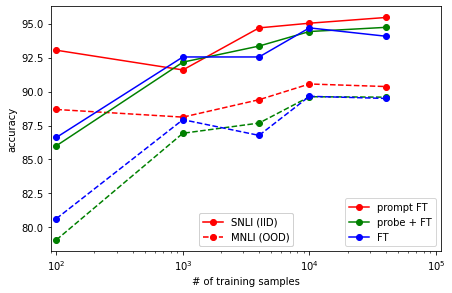

In [41]:
fig, ax = plt.subplots(figsize=(7,4.5))
plot_iid_ood(path_3, iid_domain=dataset, ood_domain=ood_dataset, ax=ax, color='r', label='prompt FT')
plot_iid_ood(path_2, iid_domain=dataset, ood_domain=ood_dataset, ax=ax, color='g', label='probe + FT')
plot_iid_ood(path_1, iid_domain=dataset, ood_domain=ood_dataset, ax=ax, color='b', label='FT')

plt.legend()
ax.set_xscale('log')
plt.xlabel('# of training samples')
plt.ylabel('accuracy')
plt.xlim(90,110_000)

# create second (And first legend)
lines = ax.get_lines()
legend1 = plt.legend([lines[i] for i in [0,2,4]], ["prompt FT", "probe + FT", "FT"], loc=4)
legend2 = plt.legend([lines[i] for i in [0,1]], ["SNLI (IID)", "MNLI (OOD)"], loc=8)
ax.add_artist(legend1)
ax.add_artist(legend2)


No handles with labels found to put in legend.


(100, 100000)

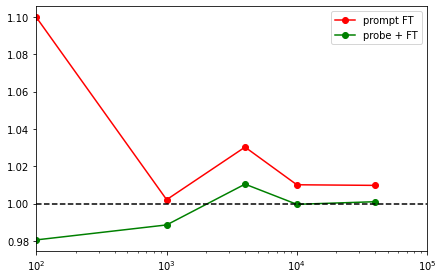

In [42]:
fig, ax = plt.subplots(figsize=(7,4.5))

mark_plot([path_1, path_3, path_2], domain=ood_dataset, ax=ax)

plt.legend()
ax.set_xscale('log')
plt.legend(['prompt FT', 'probe + FT'])

plt.xlim(100, 100000)


No handles with labels found to put in legend.


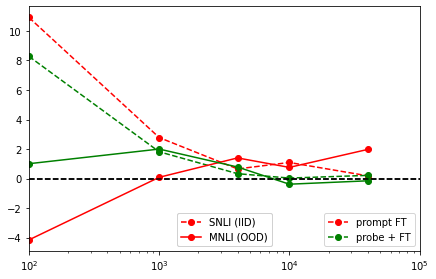

In [10]:
fig, ax = plt.subplots(figsize=(7,4.5))

mark_plot([path_1, path_3, path_2], domain=dataset, ax=ax, linestyle='--')
mark_plot([path_1, path_3, path_2], domain=ood_dataset, ax=ax)

plt.legend()
ax.set_xscale('log')
plt.legend(['prompt FT', 'probe + FT'])

plt.xlim(100, 100000)

# create second (And first legend)
lines = ax.get_lines()
legend1 = plt.legend([lines[i] for i in [0,1]], ["prompt FT", "probe + FT"], loc=4)
legend2 = plt.legend([lines[i] for i in [0,3]], ["SNLI (IID)", "MNLI (OOD)"], loc=8)
ax.add_artist(legend1)
ax.add_artist(legend2)


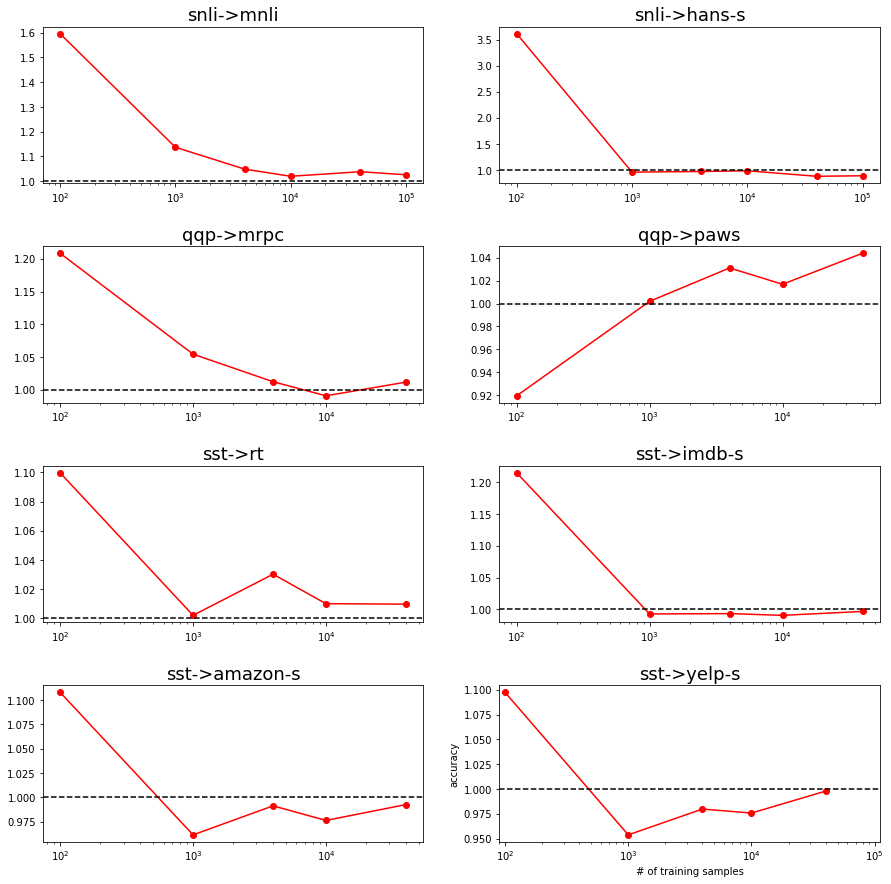

In [74]:
domain_pairs = [('snli', 'mnli'), ('snli', 'hans-s'), 
                ('qqp', 'mrpc'), ('qqp', 'paws'),
                ('sst', 'rt'), ('sst', 'imdb-s'), ('sst', 'amazon-s'), ('sst', 'yelp-s')]

fig, axs = plt.subplots(4, 2, figsize=(15,15))
plt.subplots_adjust(hspace=0.4)

for k, (iid, ood) in enumerate(domain_pairs):
    ax = axs[k//2, k%2]
    path_1 = f'models/{iid}/prompt-{transformer}/curve.json'   
    path_2 = f'models/{iid}/finetune-{transformer}/curve.json'

    #plot_iid_ood(path_1, iid_domain=iid, ood_domain=ood, ax=ax, color='r', label='prompt FT')
    #plot_iid_ood(path_2, iid_domain=iid, ood_domain=ood, ax=ax, color='b', label='FT')
    mark_plot([path_2, path_1], domain=ood, ax=ax)

    #format graph
    ax.set_xscale('log')
    ax.set_title(f'{iid}->{ood}', size=18)
    plt.xlabel('# of training samples')
    plt.ylabel('accuracy')
    plt.xlim(90,110_000)


### DEBERTA RESULTS

In [34]:
transformer = 'deberta-xl'
dataset = 'qqp'
ood_dataset = 'mrpc'

path_1 = f'models/{dataset}/finetune-{transformer}/curve.json'
path_2 = f'models/{dataset}/prompt-{transformer}/curve.json'

(90, 110000)

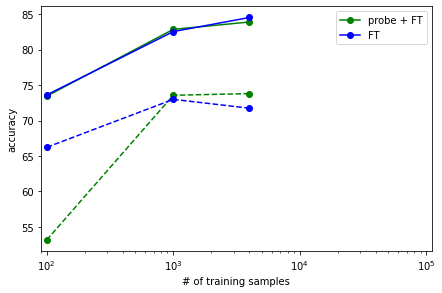

In [35]:
fig, ax = plt.subplots(figsize=(7,4.5))
plot_iid_ood(path_2, iid_domain=dataset, ood_domain=ood_dataset, ax=ax, color='g', label='probe + FT')
plot_iid_ood(path_1, iid_domain=dataset, ood_domain=ood_dataset, ax=ax, color='b', label='FT')

plt.legend()
ax.set_xscale('log')
plt.xlabel('# of training samples')
plt.ylabel('accuracy')
plt.xlim(90,110_000)


In [ ]:
def iid_ood_plot(path, **kwargs):
    output = get_model_perf(path)
    
    domains = list(output.keys())
    lims = sorted(output[domains[0]].keys())

    points = []
    for lim in lims:
        iid_acc = output[domains[0]][lim][0]
        ood_acc = output[domains[1]][lim][0]
        points.append((ood_acc, iid_acc))
    plt.plot(*zip(*points), marker='o', markersize=8, **kwargs)
    

In [ ]:
for trans_name in ['roberta', 'bert']:
    for size in ['base', 'large']:
        path_1 = f'models/snli/FT-{trans_name}-{size}/curve.json'
        path_2 = f'models/snli/prompt-{trans_name}-{size}/curve.json'
        iid_ood_plot(path_1, linestyle='--')
        iid_ood_plot(path_2, linestyle='-')
        plt.show()

In [ ]:
def get_model_perf(path, points=[10, 100, 1000, 5000, 10000]):
    data = load_json(path)
    domains = list(data.values())[0]['1'].keys()

    output = defaultdict(dict)
    for lim in data.keys():
        if len(data[lim].keys()) < 5:
            continue
        
        for domain in domains:
            accs = [data[lim][seed_num][domain] for seed_num in data[lim].keys()]
            mean = np.mean(accs)
            std = np.std(accs)
            output[domain][int(lim)] = [mean, std]
            
    return output

def get_table_row(path, points=[10, 100, 1000, 5000, 10000]):
    """ formats the results to go into the table in the paper """
    output = get_model_perf(path)
    header = ''
    msg = ''
    for domain in output.keys():
        for lim in points:
            head = 'k'.join(str(lim).rsplit('000', 1))
            header += f' & {head:<4}'
            if lim in output[domain]:
                mean = output[domain][lim][0]
                msg += f' & {mean:.1f}' #\std{{{row[1]:.1f}}}'
            else:
                msg += f' &  -  ' #\std{{{row[2]:.1f}}}'
    print(header)
    print(msg)
        